# CIFAR 10 - AlexNet


In [97]:
# Importações
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import _LRScheduler
import torch.utils.data as data

import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torchvision import models
from torchvision.datasets import CIFAR10

from sklearn import decomposition
from sklearn import manifold
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from tqdm.notebook import tqdm, trange
import matplotlib.pyplot as plt
import numpy as np

import copy
import random
import time

In [98]:
# Definição da semente aleatória para que todos os experimentos possam ser reproduzidos.

## Configurações
# Hyperparameters
RANDOM_SEED = 1
LEARNING_RATE = 0.0001
BATCH_SIZE = 256
NUM_EPOCHS = 40

# Architecture
NUM_CLASSES = 10

# Other
DEVICE = "cuda:0"

SEED = 1234
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

In [99]:
# Variveis Globais
DATA_DIR = './'
CATEGORIES = ['Avião', 'Automóvel','Passáro','Gato','Cervo','Cachorro', 'Sapo', 'Cavalo', 'Navio', 'Caminhão']

In [100]:
# Dados
cifar10_train = CIFAR10(DATA_DIR, train=True, download=True)
cifar10_test = CIFAR10(DATA_DIR, train=False, download=True)

Files already downloaded and verified
Files already downloaded and verified


In [101]:
# Visualização da Quantidade de dados
print(f"Quantidade de Dados para Treinamento : {len(cifar10_train)}")
print(f"Quantidade de Dados para Teste : {len(cifar10_test)}" )

Quantidade de Dados para Treinamento : 50000
Quantidade de Dados para Teste : 10000


In [102]:
# Preparando a Transformação e Normalização dos dados
import torchvision.transforms as tt

prep_transform = transforms.Compose([transforms.Resize((70, 70)),
                                       transforms.RandomCrop((64, 64)),
                                       #transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2470, 0.2435, 0.2616)),
                                       transforms.ToTensor()])


In [103]:
# Normalizando e Tensor dos dados

train_size = int(len(cifar10_train) * 0.8) # 80% Dados de Treinamento
valid_size = len(cifar10_train) - train_size # 20% Dados de Validação

tensor_train = CIFAR10(DATA_DIR, train=True, download=False, transform=prep_transform)
tensor_test = CIFAR10(DATA_DIR, train=False, download=False, transform=prep_transform)
tensor_train, tensor_validation = torch.utils.data.random_split(tensor_train, [train_size, valid_size])


In [104]:
from torch.utils.data import DataLoader
train_loader = DataLoader(tensor_train, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(tensor_test, batch_size=BATCH_SIZE, shuffle=True)
validation_loader=DataLoader(tensor_validation, batch_size=BATCH_SIZE, shuffle=True)

In [105]:
# Dados sobre imagens
print('Conjunto de Treinamento:\n')
for images, labels in train_loader:
    print('Dimensões do lote de imagens:', images.size())
    print('Dimensões do lote de rotulos:', labels.size())
    print(labels[:10])
    break

print('\nConjunto de Validação:\n')
for images, labels in validation_loader:
    print('Dimensões do lote de imagens:', images.size())
    print('Dimensões do lote de rotulos:', labels.size())
    print(labels[:10])
    break

print('\nConjunto de Teste :\n')
for images, labels in train_loader:
    print('Dimensões do lote de imagens:', images.size())
    print('Dimensões do lote de rotulos:', labels.size())
    print(labels[:10])
    break

Conjunto de Treinamento:

Dimensões do lote de imagens: torch.Size([256, 3, 64, 64])
Dimensões do lote de rotulos: torch.Size([256])
tensor([9, 1, 5, 5, 0, 5, 1, 0, 4, 2])

Conjunto de Validação:

Dimensões do lote de imagens: torch.Size([256, 3, 64, 64])
Dimensões do lote de rotulos: torch.Size([256])
tensor([4, 6, 3, 0, 5, 1, 6, 7, 0, 3])

Conjunto de Teste :

Dimensões do lote de imagens: torch.Size([256, 3, 64, 64])
Dimensões do lote de rotulos: torch.Size([256])
tensor([4, 2, 2, 4, 3, 2, 2, 7, 4, 2])


In [106]:
# Modelo da Rede
class AlexNet(nn.Module):
    def __init__(self, num_classes):
        super(AlexNet, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=11, stride=4, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),

            nn.Conv2d(64, 192, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),

            nn.Conv2d(192, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),

            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),

            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
        )
        self.avgpool = nn.AdaptiveAvgPool2d((6, 6))
        self.classifier = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(256 * 6 * 6, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = x.view(x.size(0), 256 * 6 * 6)
        logits = self.classifier(x)
        probas = F.softmax(logits, dim=1)
        return logits

In [107]:
torch.manual_seed(RANDOM_SEED)

model = AlexNet(NUM_CLASSES)
model.to(DEVICE)
lossfunc = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

In [108]:
import numpy as np
from itertools import product

# Função de Acurácia e Erro

def compute_accuracy(model, data_loader, device):
    model.eval()
    with torch.no_grad():
        correct_pred, num_examples = 0, 0
        for i, (features, targets) in enumerate(data_loader):

            features = features.to(device)
            targets = targets.to(device)

            logits = model(features)
            if isinstance(logits, torch.distributed.rpc.api.RRef):
                logits = logits.local_value()
            _, predicted_labels = torch.max(logits, 1)
            num_examples += targets.size(0)
            correct_pred += (predicted_labels == targets).sum()
    return correct_pred.float()/num_examples * 100


def compute_epoch_loss(model, data_loader, device):
    model.eval()
    curr_loss, num_examples = 0., 0
    with torch.no_grad():
        for features, targets in data_loader:
            features = features.to(device)
            targets = targets.to(device)
            logits = model(features)
            if isinstance(logits, torch.distributed.rpc.api.RRef):
                logits = logits.local_value()
            loss = F.cross_entropy(logits, targets, reduction='sum')
            num_examples += targets.size(0)
            curr_loss += loss

        curr_loss = curr_loss / num_examples
        return curr_loss


In [109]:
def train_network(num_epochs, model, optimizer, device,
                               train_loader, valid_loader=None,
                               loss_fn=None, logging_interval=100,
                               skip_epoch_stats=False):

    log_dict = {'train_loss_per_batch': [],
                'train_acc_per_epoch': [],
                'train_loss_per_epoch': [],
                'valid_acc_per_epoch': [],
                'valid_loss_per_epoch': []}

    if loss_fn is None:
        loss_fn = F.cross_entropy

    start_time = time.time()
    for epoch in range(num_epochs):

        model.train()
        for batch_idx, (features, targets) in enumerate(train_loader):

            features = features.to(device)
            targets = targets.to(device)

            # FORWARD AND BACK PROP
            logits = model(features)
            if isinstance(logits, torch.distributed.rpc.api.RRef):
                logits = logits.local_value()
            loss = loss_fn(logits, targets)
            optimizer.zero_grad()

            loss.backward()

            # UPDATE MODEL PARAMETERS
            optimizer.step()

            # LOGGING
            log_dict['train_loss_per_batch'].append(loss.item())

            if not batch_idx % logging_interval:
                print('Epoca: %03d/%03d | Lote %04d/%04d | Taxa de Erro: %.4f'
                      % (epoch+1, num_epochs, batch_idx,
                          len(train_loader), loss))

        if not skip_epoch_stats:
            model.eval()

            with torch.set_grad_enabled(False):  # save memory during inference

                train_acc = compute_accuracy(model, train_loader, device)
                train_loss = compute_epoch_loss(model, train_loader, device)
                print('***Epoca: %03d/%03d | Treinamento. Acc.: %.3f%% | Taxa de Erro: %.3f' % (
                      epoch+1, num_epochs, train_acc, train_loss))
                log_dict['train_loss_per_epoch'].append(train_loss.item())
                log_dict['train_acc_per_epoch'].append(train_acc.item())

                if valid_loader is not None:
                    valid_acc = compute_accuracy(model, valid_loader, device)
                    valid_loss = compute_epoch_loss(model, valid_loader, device)
                    print('***Epoca: %03d/%03d | Validação. Acc.: %.3f%% | Taxa de Erro: %.3f' % (
                          epoch+1, num_epochs, valid_acc, valid_loss))
                    log_dict['valid_loss_per_epoch'].append(valid_loss.item())
                    log_dict['valid_acc_per_epoch'].append(valid_acc.item())

        print('Tempo Decorrido: %.2f min' % ((time.time() - start_time)/60))

    print('Tempo de Treinamento Total: %.2f min' % ((time.time() - start_time)/60))

    return log_dict

In [110]:
log_dict = train_network(NUM_EPOCHS, model, optimizer, DEVICE, train_loader, validation_loader, lossfunc, logging_interval=50)

Epoca: 001/040 | Lote 0000/0157 | Taxa de Erro: 2.3031
Epoca: 001/040 | Lote 0050/0157 | Taxa de Erro: 2.0104
Epoca: 001/040 | Lote 0100/0157 | Taxa de Erro: 1.9035
Epoca: 001/040 | Lote 0150/0157 | Taxa de Erro: 1.6893
***Epoca: 001/040 | Treinamento. Acc.: 33.083% | Taxa de Erro: 1.704
***Epoca: 001/040 | Validação. Acc.: 32.370% | Taxa de Erro: 1.709
Tempo Decorrido: 0.98 min
Epoca: 002/040 | Lote 0000/0157 | Taxa de Erro: 1.6873
Epoca: 002/040 | Lote 0050/0157 | Taxa de Erro: 1.6803
Epoca: 002/040 | Lote 0100/0157 | Taxa de Erro: 1.6541
Epoca: 002/040 | Lote 0150/0157 | Taxa de Erro: 1.6406
***Epoca: 002/040 | Treinamento. Acc.: 40.045% | Taxa de Erro: 1.552
***Epoca: 002/040 | Validação. Acc.: 39.950% | Taxa de Erro: 1.567
Tempo Decorrido: 2.00 min
Epoca: 003/040 | Lote 0000/0157 | Taxa de Erro: 1.5059
Epoca: 003/040 | Lote 0050/0157 | Taxa de Erro: 1.4040
Epoca: 003/040 | Lote 0100/0157 | Taxa de Erro: 1.5228
Epoca: 003/040 | Lote 0150/0157 | Taxa de Erro: 1.4679
***Epoca: 003/04

# Métricas de Avaliação


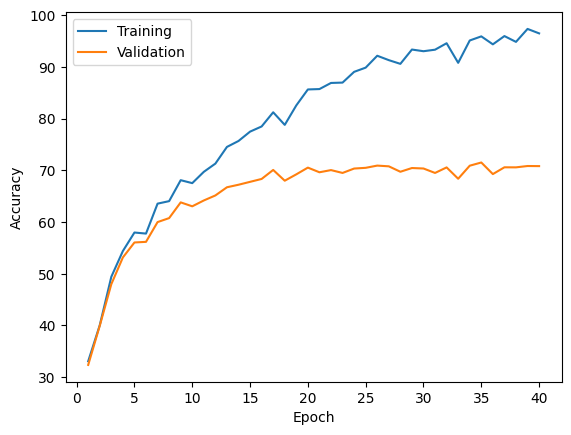

In [111]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(np.arange(1, NUM_EPOCHS+1), log_dict['train_acc_per_epoch'], label='Training')
plt.plot(np.arange(1, NUM_EPOCHS+1), log_dict['valid_acc_per_epoch'], label='Validation')

plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [115]:
with torch.set_grad_enabled(False):

    train_acc = compute_accuracy(model=model,
                                 data_loader=train_loader,
                                 device=DEVICE)

    test_acc = compute_accuracy(model=model,
                                data_loader=test_loader,
                                device=DEVICE)

    valid_acc = compute_accuracy(model=model,
                                 data_loader=validation_loader,
                                 device=DEVICE)


print(f'Treinamento ACC: {train_acc:.2f}%')
print(f'Validação ACC: {valid_acc:.2f}%')
print(f'Teste ACC: {test_acc:.2f}%')

Treinamento ACC: 96.48%
Validação ACC: 70.13%
Teste ACC: 70.24%


# Teste com uma Imagem

In [138]:
import sysconfig
from PIL import Image
img = Image.open('./Gato.jpeg')

In [139]:
img_tensor = prep_transform(img)

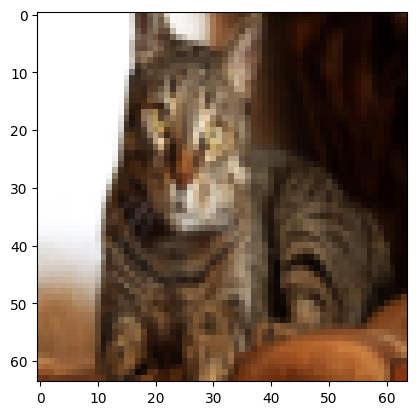

In [140]:
plt.imshow(img_tensor.permute(1,2, 0))

In [141]:
batch = img_tensor.unsqueeze(0).to(DEVICE)

In [143]:
import operator
output = model(batch)
logits = torch.nn.functional.softmax(output, dim=1) * 100
prob_dict = {}

for i, classname in enumerate(CATEGORIES):
  prob = logits[0][i].item()
  prob_dict[classname] = [prob]

result = max(prob_dict.items(), key=operator.itemgetter(1))
result

('Gato', [85.19236755371094])